# Climate Modelling Project - 1D Graphics

---------------

## 0. Import Libraries

In [1]:
import xarray as xr
import rioxarray
from datetime import datetime
from scipy.constants import g
import geopandas as gpd
import cartopy
from shapely.geometry import mapping
from visjobs.datas import get_ERA5
import requests
from bs4 import BeautifulSoup 
import matplotlib
import proplot
import cartopy
import matplotlib.pyplot as plt
from visualization_codes import plot_facet_map
import pandas as pd
from matplotlib.colors import BoundaryNorm
import numpy as np
from functions import *

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

----------

## 1. Open Data

In [2]:
path = r'Data/'
single = 'Merged_New_Single.nc'
pressure = 'Merged_New_Pressure.nc'
shapefile = r'tr_shapefiles/Iller_HGK_6360_Kanun_Sonrasi.shp'
is_single = True
model_var = 'T_2M' # possible for single: PMSL, RELHUM_2M, TOT_PREC, T_2M, U_10M, V_10M
                 # possible for pressure: FI, RELHUM, T
era5_var = 't2m' # possible for single: u10, v10, t2m, msl, tp
                 # possible for pressure: z, t
    
if is_single:
    
    # model data
    dt = xr.open_dataset(path + single).sel(time = '2013')[model_var]
    # era5 data
    dt_era5 = xr.open_dataset(path + 'ERA5/single_level_era5.nc')[era5_var]

else:
    
    # model data
    dt = xr.open_dataset(path + pressure).sel(time = '2013')[model_var]
    # era5 data
    dt_era5 = xr.open_dataset(path + 'ERA5/pressure_level_era5.nc')[era5_var]

# adjust units to known units
dt = adjust_unit(dt, model_var)
dt_era5 = adjust_unit(dt_era5, era5_var)

# shapefile
shapefile_dt = gpd.read_file(path + shapefile)

In [3]:
dt

<xarray.DataArray 'T_2M' (time: 1460, rlat: 48, rlon: 62)>
array([[[15.791229  , 15.880066  , 15.951324  , ..., 19.035675  ,
         19.568787  , 19.34085   ],
        [15.707001  , 15.791809  , 15.864044  , ..., 18.927277  ,
         19.54544   , 19.446045  ],
        [15.599823  , 15.747437  , 15.84671   , ..., 18.827087  ,
         19.434998  , 19.365173  ],
        ...,
        [ 1.6021118 , -0.73880005, -2.2884521 , ...,  8.92981   ,
          8.962463  ,  8.986877  ],
        [-0.9824829 , -3.374176  , -4.998535  , ...,  8.437714  ,
          8.537079  ,  8.652832  ],
        [-3.6299133 , -5.8056946 , -6.6781006 , ...,  7.9447327 ,
          8.124542  ,  8.317169  ]],

       [[15.713318  , 15.783478  , 15.846985  , ..., 18.453278  ,
         18.90335   , 18.74292   ],
        [15.670563  , 15.745056  , 15.807556  , ..., 18.405151  ,
         18.989868  , 18.97464   ],
        [15.610016  , 15.7677    , 15.847137  , ..., 18.334137  ,
         18.944763  , 18.973633  ],
...
        [12.828644  , 12.417267  , 11.664215  , ...,  6.273773  ,
          6.1557007 ,  6.0782776 ],
        [10.989044  ,  9.134094  ,  8.012604  , ...,  5.94751   ,
          5.848999  ,  5.783966  ],
        [ 7.662201  ,  5.268402  ,  4.4761963 , ...,  5.64447   ,
          5.5598755 ,  5.5006104 ]],

       [[15.172516  , 15.036316  , 15.012329  , ..., 15.910034  ,
         16.110077  , 15.926788  ],
        [15.201721  , 14.997284  , 14.914917  , ..., 15.893799  ,
         16.102814  , 15.965942  ],
        [15.351196  , 15.121277  , 14.975128  , ..., 15.885468  ,
         16.086365  , 15.976105  ],
        ...,
        [11.517059  , 10.524078  ,  9.389038  , ...,  6.0073547 ,
          5.9765015 ,  6.038086  ],
        [ 8.965698  ,  6.67511   ,  5.1602783 , ...,  5.7792053 ,
          5.789215  ,  5.8923035 ],
        [ 4.791809  ,  2.0192566 ,  1.1325684 , ...,  5.542755  ,
          5.603485  ,  5.746399  ]]], dtype=float32)
Coordinates:
    lat      (rlat, rlon) float32 ...
    lon      (rlat, rlon) float32 ...
  * rlat     (rlat) float32 -3.16 -2.94 -2.72 -2.5 -2.28 ... 6.52 6.74 6.96 7.18
  * rlon     (rlon) float32 -8.78 -8.56 -8.34 -8.12 -7.9 ... 3.98 4.2 4.42 4.64
  * time     (time) datetime64[ns] 2013-01-01 ... 2013-12-31T18:00:00

In [4]:
dt_era5

<xarray.DataArray 't2m' (time: 8760, latitude: 81, longitude: 101)>
array([[[ 0.96203613,  0.32815552,  0.50180054, ..., -2.1062622 ,
         -2.140747  , -2.140747  ],
        [ 1.4662781 ,  0.858551  ,  0.4078369 , ..., -2.1728516 ,
         -2.2335205 , -2.2347107 ],
        [ 0.57196045,  0.07958984, -0.37350464, ..., -2.1312256 ,
         -2.1918945 , -2.2001953 ],
        ...,
        [ 8.226013  ,  8.135651  ,  8.026215  , ...,  6.8797913 ,
          7.2068176 ,  7.235382  ],
        [ 8.114227  ,  8.179657  ,  8.212952  , ...,  7.458954  ,
          7.3103027 ,  7.4018555 ],
        [ 7.655182  ,  8.143951  ,  7.92157   , ...,  7.4351807 ,
          7.1830444 ,  7.4197083 ]],

       [[ 0.9096985 ,  0.29962158,  0.5303345 , ..., -2.4249878 ,
         -2.3619385 , -2.294159  ],
        [ 1.3509216 ,  0.75509644,  0.2591858 , ..., -2.4404297 ,
         -2.477295  , -2.4142761 ],
        [ 0.42684937, -0.17489624, -0.6708069 , ..., -2.3797913 ,
         -2.4142761 , -2.3976135 ],
...
        [10.727051  , 10.478485  ,  9.8125    , ...,  4.638031  ,
          4.7046204 ,  4.780731  ],
        [10.150238  , 10.114563  ,  9.433136  , ...,  4.9317627 ,
          5.0090637 ,  5.275482  ],
        [ 9.165527  ,  9.285645  ,  8.968109  , ...,  5.2504883 ,
          5.458618  ,  5.8451233 ]],

       [[ 2.5282898 ,  2.7982483 ,  2.9468994 , ..., -1.301117  ,
         -1.1964722 , -1.1940918 ],
        [ 1.7421875 ,  1.9919434 ,  1.989563  , ..., -1.217865  ,
         -1.355835  , -1.3713074 ],
        [ 1.173706  ,  1.2355652 ,  1.234375  , ..., -1.1239319 ,
         -1.2642517 , -1.3403625 ],
        ...,
        [10.210907  ,  9.970673  ,  9.39743   , ...,  5.155365  ,
          5.1398926 ,  5.05188   ],
        [ 9.540161  ,  9.39624   ,  8.952667  , ...,  5.3277893 ,
          5.3432617 ,  5.4681396 ],
        [ 8.69458   ,  8.664856  ,  8.390137  , ...,  5.239807  ,
          5.485962  ,  5.786865  ]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 15.0 15.25 15.5 15.75 ... 39.5 39.75 40.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 30.5 30.25 30.0
  * time       (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00

----------

## 2. Functions

In [5]:
# Retrieved functions from function.py in the current directory

-------------

## 3 Assign Projection Info to Datasets

### 3.1 Model Data

In [6]:
# General data information
crs_parameters = {'pole_longitude': -151.0,
                  'pole_latitude': 53.0,
                  }
crs_data = cartopy.crs.RotatedPole(**crs_parameters).proj4_params
x_dims = 'rlon'
y_dims = 'rlat'

# assign proj info
dt = assing_proj_info(dt, crs_data, x_dims, y_dims)

### 3.2 ERA5 Data

In [7]:
# General data information
crs_data_era5 = 4326
x_dims_era5 = 'longitude'
y_dims_era5 = 'latitude'

# assign proj info
dt_era5 = assing_proj_info(dt_era5, crs_data_era5, x_dims_era5, y_dims_era5)

## 4. Reproject ERA5 Matching Model Data

In [8]:
# single dt
dt_era5_reprojected = dt_era5.rio.reproject_match(dt) \
                              .rename({'y':'rlat', 'x':'rlon', })
dt_era5_reprojected = dt_era5_reprojected.assign_coords(dict(
                            lon=(["rlat", "rlon"], dt['lon'].values),
                            lat=(["rlat", "rlon"], dt['lat'].values)))

In [46]:
dt_era5_reprojected

<xarray.DataArray 't2m' (time: 8760, rlat: 48, rlon: 62)>
array([[[14.761017  , 14.724121  , 14.753876  , ..., 17.899445  ,
         18.087372  , 18.28833   ],
        [14.57547   , 14.724121  , 14.753876  , ..., 17.774597  ,
         17.86853   , 18.167053  ],
        [14.50769   , 14.673004  , 14.796692  , ..., 17.782898  ,
         17.79242   , 18.095673  ],
        ...,
        [ 5.1327515 ,  0.85739136, -0.8539734 , ...,  9.107269  ,
          9.064453  ,  9.083466  ],
        [ 0.9096985 , -2.0646362 , -2.5879211 , ...,  8.62204   ,
          8.69696   ,  8.702911  ],
        [ 0.9096985 , -3.3312073 , -5.2268677 , ...,  8.293823  ,
          8.354462  ,  8.354462  ]],

       [[14.441101  , 14.349518  , 14.569519  , ..., 17.947021  ,
         18.100433  , 18.306183  ],
        [14.255554  , 14.349518  , 14.569519  , ..., 17.826904  ,
         17.899445  , 18.199158  ],
        [14.208008  , 14.332855  , 14.665863  , ..., 17.816193  ,
         17.843567  , 18.121857  ],
...
        [10.011108  ,  8.215332  ,  6.853607  , ...,  7.130707  ,
          7.5410156 ,  7.9310913 ],
        [ 6.2244873 ,  4.4216003 ,  5.1874695 , ...,  6.8964233 ,
          7.3007812 ,  7.810974  ],
        [ 6.2244873 ,  1.6446533 ,  3.4000244 , ...,  6.306549  ,
          6.6966248 ,  7.3007812 ]],

       [[16.211884  , 16.101288  , 16.134583  , ..., 15.545898  ,
         15.560181  , 15.5578    ],
        [16.028748  , 16.101288  , 16.134583  , ..., 15.495972  ,
         15.448395  , 15.518555  ],
        [15.8349    , 15.928864  , 16.04422   , ..., 15.405579  ,
         15.387756  , 15.393677  ],
        ...,
        [ 9.819641  ,  8.116608  ,  6.7549133 , ...,  7.441101  ,
          7.818115  ,  8.143951  ],
        [ 6.38385   ,  4.6356506 ,  5.1636963 , ...,  7.180664  ,
          7.5635986 ,  7.9608154 ],
        [ 6.38385   ,  2.4509888 ,  3.677124  , ...,  6.5598755 ,
          6.9463806 ,  7.4137573 ]]], dtype=float32)
Coordinates:
  * rlon         (rlon) float64 -8.78 -8.56 -8.34 -8.12 ... 3.98 4.2 4.42 4.64
  * rlat         (rlat) float64 -3.16 -2.94 -2.72 -2.5 ... 6.52 6.74 6.96 7.18
  * time         (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
    spatial_ref  int64 0
    lon          (rlat, rlon) float32 18.49 18.75 19.01 ... 34.8 35.11 35.41
    lat          (rlat, rlon) float32 33.36 33.38 33.4 ... 44.05 44.04 44.02
Attributes:
    _FillValue:  3.402823466e+38

--------

## 5. Clip Data to Specific Province

In [10]:
# choose province to clip
province = shapefile_dt.query(f'IL == "ANTALYA"')

### 5.1 Check If Clipping is Accurate by Making Data Higher Resolution

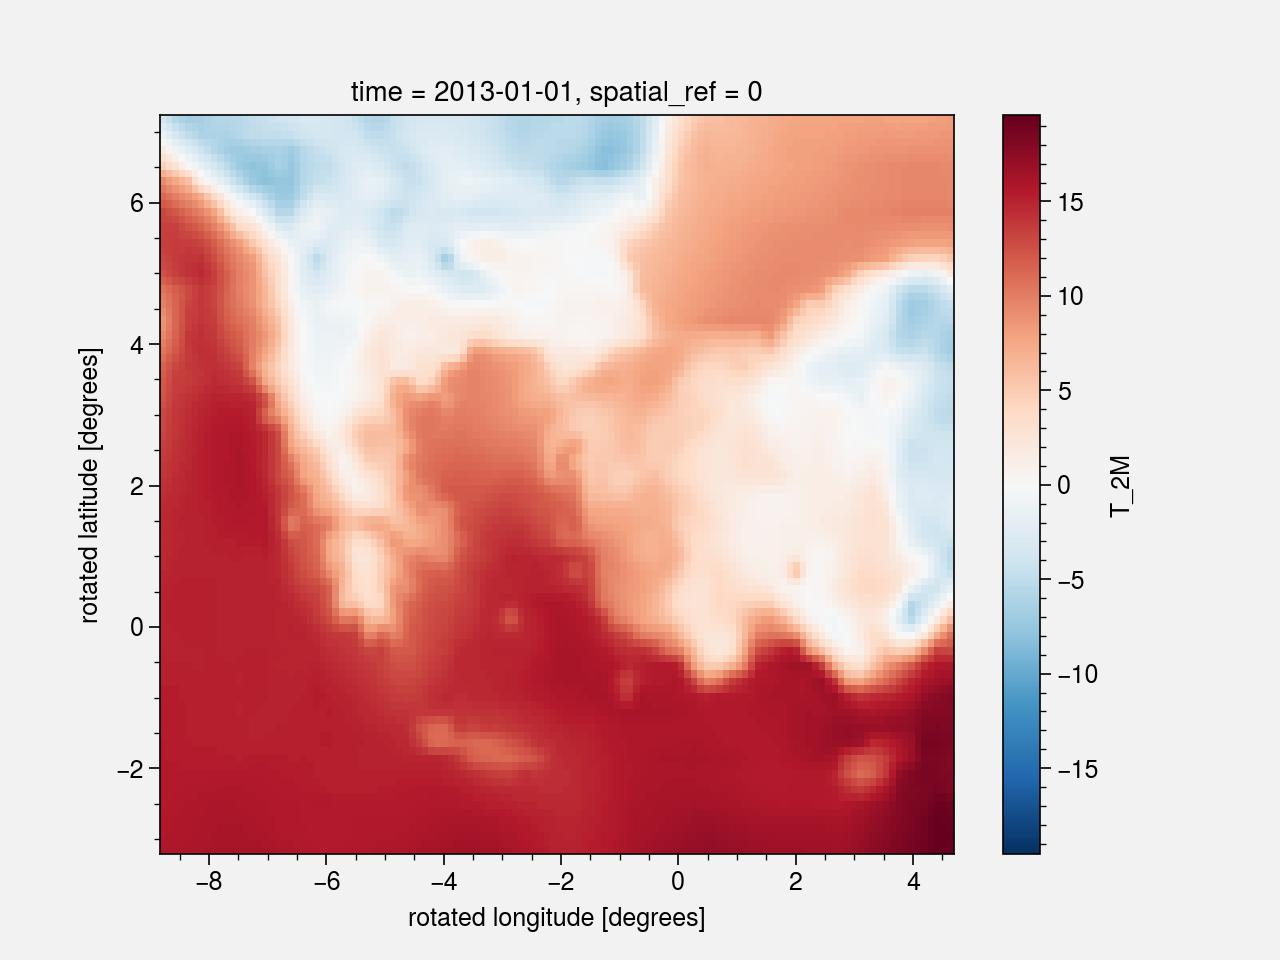

In [11]:
# test clipping accuracy
higher_resolution(dt, x_dims, y_dims, 2)[0].plot()

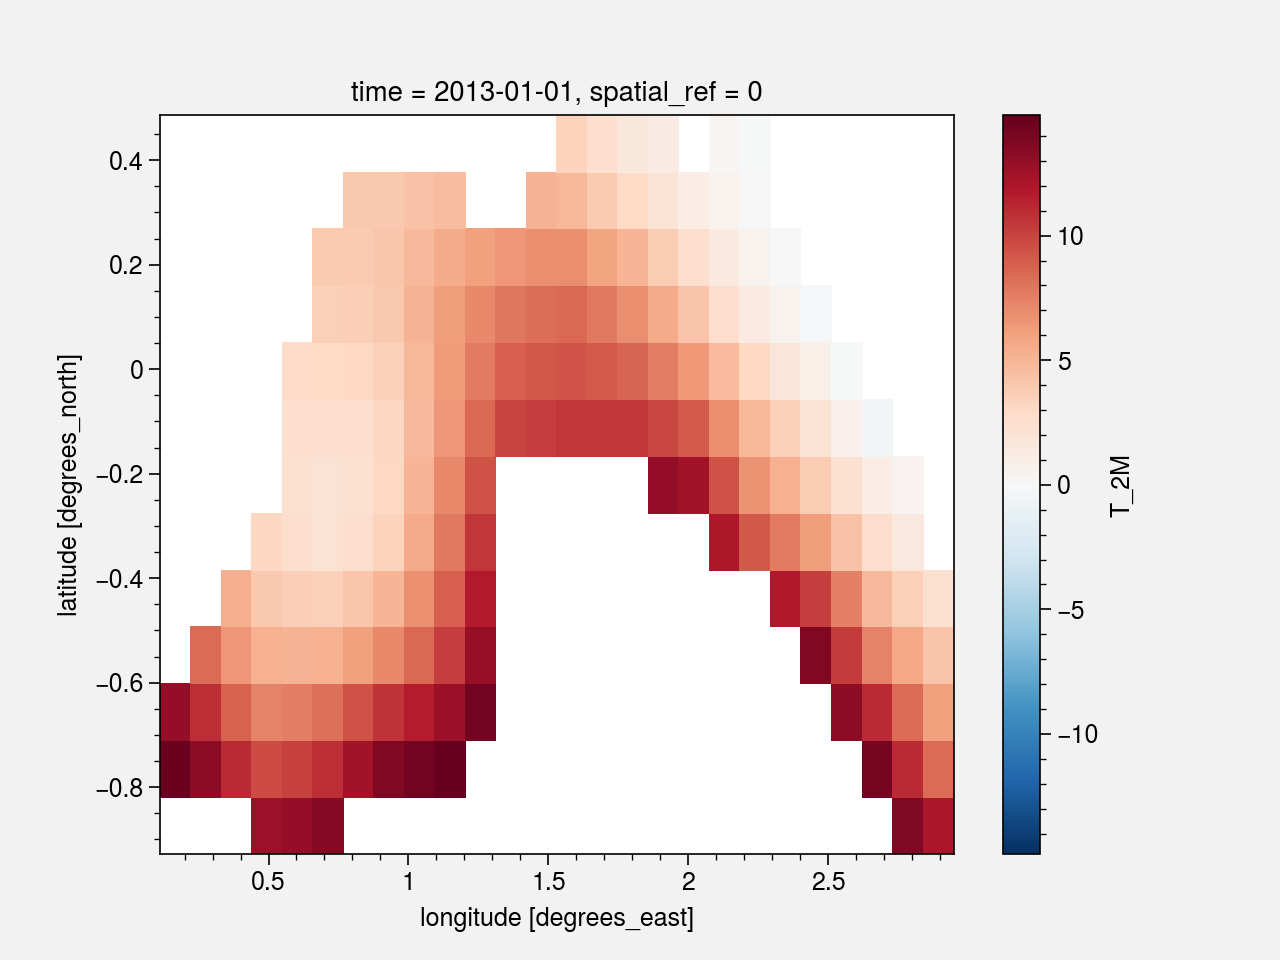

In [12]:
# test clipping accuracy
clip_to_city(higher_resolution(dt, x_dims, y_dims, 2),
             province, crs_data, x_dims, y_dims)[0].plot()

In [13]:
# test looks accurate: Antalya is clipped

### 5.2 Clip

In [77]:
# model
dt_clipped = clip_to_city(dt, province, crs_data, x_dims, y_dims)
# era5
dt_era5_clipped = clip_to_city(dt_era5_reprojected, province, crs_data, x_dims, y_dims)
# it adds fillvalue (IDK why?) so better change no data with np.nan
nodata = dt_era5_clipped.rio.nodata
dt_era5_clipped = dt_era5_clipped.where(dt_era5_clipped != nodata, np.nan)

/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/rioxarray/raster_writer.py:108: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


----------

## 6. Spatially Average Clipped Data

In [81]:
# mean model
dt_clipped_mean = dt_clipped.mean(dim=[x_dims, y_dims])
# mean era5
dt_era5_clipped_mean = dt_era5_clipped.mean(dim=[x_dims, y_dims])

mean_difference = dt_clipped_mean - dt_era5_clipped_mean

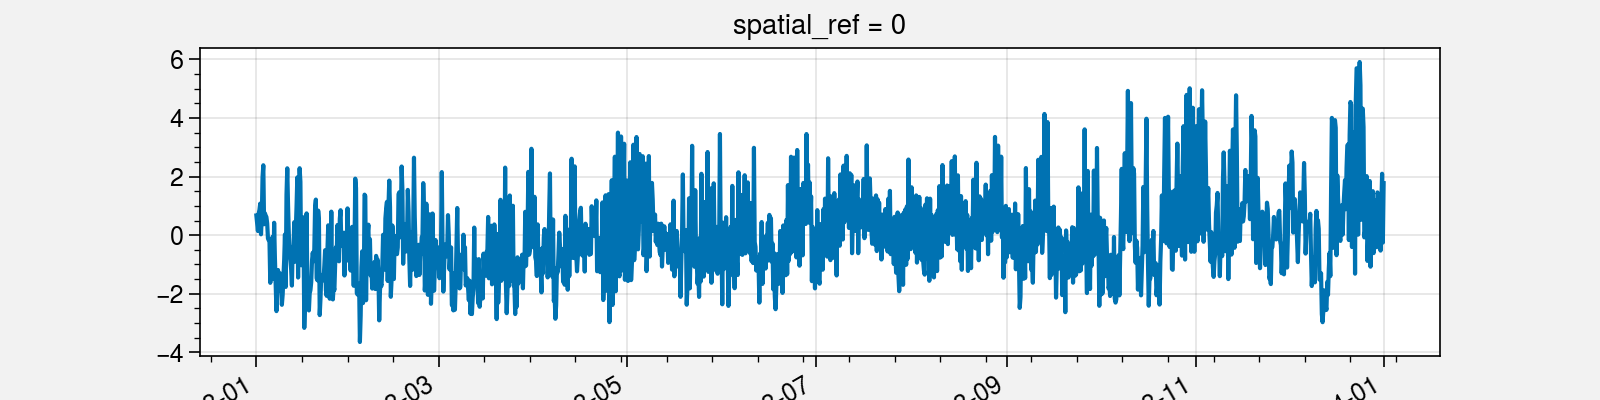

In [85]:
mean_difference.plot(figsize = (8,2))